In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict  # normal dictionary will give error if key not present
                                     # defaultdict will return default value for key not present
import numpy as np
import seaborn as sns                # for plotting nice plots
from tqdm import tqdm
import gymnasium as gym
from matplotlib.patches import Patch

In [2]:
# env = gym.make('Blackjack-v1', sab=True, render_mode="human") # sab==True -> follow sutton and barto rule
env = gym.make('Blackjack-v1', sab=True, render_mode="rgb_array") # sab==True -> follow sutton and barto rule

In [3]:
done = False
observation, info = env.reset()         # observation is a tuple (player_sum, dealer_card, usable_ace)

In [4]:
action = env.action_space.sample()                                 # action is either 0 or 1 (stick or hit)
print("action: ", action)
next_state, reward, done, truncated, info = env.step(action)       # truncated is True if episode ended due to max steps
print("observation: ", observation)                                # info is a dictionary containing all the info, eg. no of lives left in atari


action:  0
observation:  (18, 5, 1)


In [5]:
# Tabular Q-learning
"""
1) Define a Blackjack class with the following methods:
    a) init (lr, discount_factor, epsilon, decay_rate, final_epsilon, initial_eps)
    b) get_action
    3) act and update the q table
    d) epsilon decay
2) training loop to update the q table

"""

'\n1) Define a Blackjack class with the following methods:\n    a) init (lr, discount_factor, epsilon, decay_rate, final_epsilon, initial_eps)\n    b) get_action\n    3) act and update the q table\n    d) epsilon decay\n2) training loop to update the q table\n\n'

In [6]:
class BlackjackAgent:
    def __init__(
            self,
            learning_rate: float,
            discount_factor: float,
            initial_epsilon: float,
            epsilon_decay_rate: float,
            final_epsilon: float,
    ):
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        self.final_epsilon = final_epsilon
        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))
        self.training_error = []

    def get_action(self, state: tuple[int, int, bool]):
        # sample random action epsilon % of time
        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            return np.argmax(self.q_table[state])
        
    def update(self, 
               state: tuple[int, int, bool], 
               action: int, 
               reward: float, 
               terminated: bool, 
               next_state: tuple[int, int, bool]):
        
        future_q = (not terminated) * np.max(self.q_table[next_state])
        td_error = (reward + self.gamma * future_q) - self.q_table[state][action]
        self.q_table[state][action] = self.q_table[state][action] + self.lr * td_error

        self.training_error.append(td_error)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay_rate)

In [7]:
# hyperparameters
learning_rate = 0.01
n_eps = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_eps / 2)  # reduce the exploration over time
final_epsilon = 0.1
discount_factor = 0.95
agent = BlackjackAgent(learning_rate, discount_factor, start_epsilon, epsilon_decay, final_epsilon) 

In [8]:
# training loop
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_eps)       # Collects training data for n_eps
for eps in tqdm(range(n_eps)):
    state, info = env.reset()
    done = False

    while not done:
        action = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        agent.update(state, action, reward, terminated, next_state)      # no update if time elapsed (truncated)
        # frame = env.render()
        # plt.imshow(frame)
        plt.show()
        done = terminated or truncated
        state = next_state
    
    agent.decay_epsilon()




  0%|          | 54/100000 [00:31<16:11:00,  1.72it/s]


KeyboardInterrupt: 

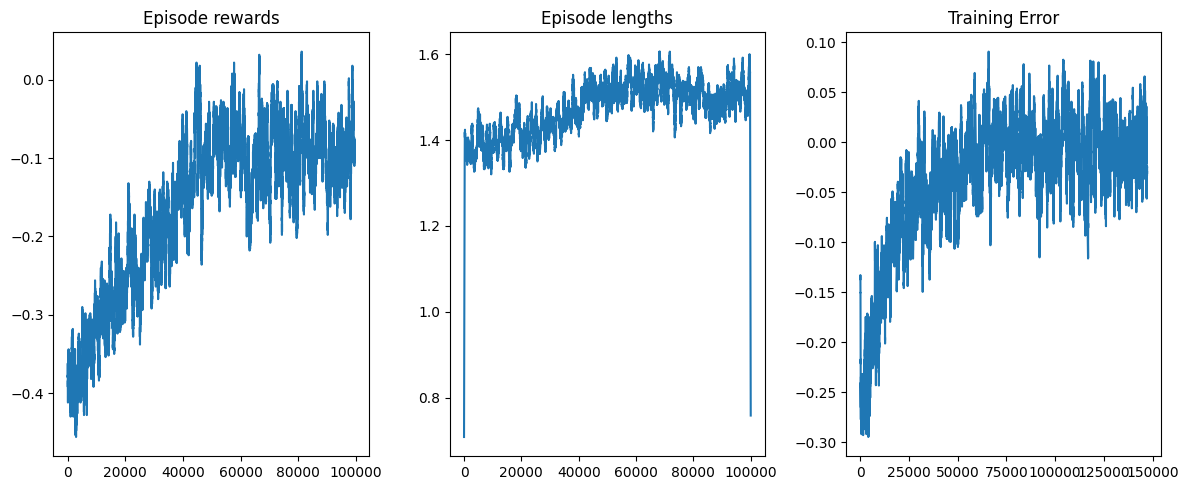

In [ ]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

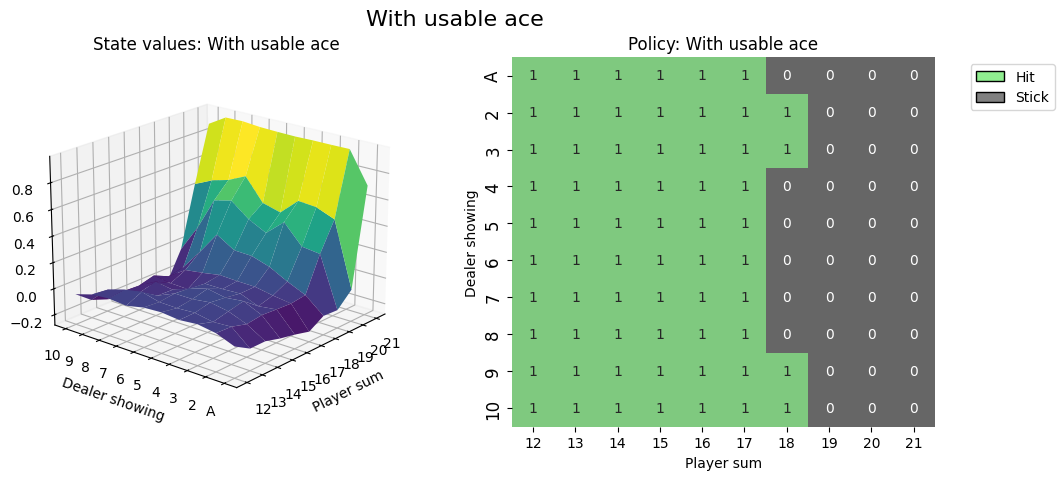

In [ ]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_table.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

In [ ]:
env.close()